In [2]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
from typing import List, Tuple, Union
import math as math 
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt

def compute_haversine(lat_long_tuple_1: tuple, lat_long_tuple_2: tuple) -> float:
    lat1, lon1 = lat_long_tuple_1
    lat2, lon2 = lat_long_tuple_2
    R_km = 6371.0088  # mean Earth radius in km
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R_km * c

def haversine_list_computer(initial_tuple, list):

    haversine_distance_list = []

    for i, entry in enumerate(list):
        haversine_distance_list.append(compute_haversine(initial_tuple, entry))

    return haversine_distance_list

def get_city_coordinates(city: str, state: str, country: str,
                         fallback: str = "nan") -> Tuple[float, float]:
    """
    Returns (latitude, longitude) of a given city, state, and country.
    
    If not found, returns:
        - (math.nan, math.nan) if fallback="nan"
        - (0.0, 0.0) if fallback="zero"
    """
    geolocator = Nominatim(user_agent="city-locator", timeout=5)

    query = f"{city}, {state}, {country}"
    location = geolocator.geocode(query)
    
    if location is None:
        if fallback == "nan":
            return (math.nan, math.nan)
        elif fallback == "zero":
            return (0.0, 0.0)
        else:
            raise ValueError("Invalid fallback option. Use 'nan' or 'zero'.")
    
    return (location.latitude, location.longitude)

def batch_get_coordinates(locations: List[Tuple[str, str, str]],
                          fallback: str = "nan",
                          pause: float = 0.05) -> List[Tuple[float, float]]:
    """
    Batch geocode a list of (city, state, country) tuples.
    Returns a list of (lat, lon) tuples.
    
    Parameters:
        locations : list of (city, state, country)
        fallback  : "nan" or "zero" for missing results
        pause     : seconds to wait between queries (default: 1.0, for Nominatim etiquette)
    """
    coords = []
    for city, state, country in locations:
        latlon = get_city_coordinates(city, state, country, fallback=fallback)
        print(len(coords), latlon)
        coords.append(latlon)
        time.sleep(pause)  # be nice to the server
    return coords

def bfs(G, source):
    """ return a dictionary that maps node-->distance for all nodes reachable
        from the source node, in the unweighted undirected graph G """
    # set of nodes left to visit
    nodes = deque()
    nodes.append(source)
    
    # dictionary that gives True or False for each node
    visited = {node:False for node in G}
    visited[source] = True
    
    # Initial distances to source are: 0 for source itself, infinity otherwise
    dist = {node: np.inf for node in G}
    dist[source] = 0
    
    # while (container) is shorthand for "while this container is not empty"
    while nodes:
        # take the earliest-added element to the deque (why do we do this instead of popright?)
        node = nodes.popleft()
        
        # visit all neighbors unless they've been visited, record their distances
        for nbr in G.neighbors(node):
            if not visited[nbr]:
                dist[nbr] = dist[node] + 1
                visited[nbr] = True
                nodes.append(nbr)
    return dist

def components(G):
    """ return a list of tuples, where each tuple is the nodes in a component of G """
    components = []
    
    nodes_left = set(G.nodes())
    while nodes_left:
        src = nodes_left.pop()
        dist = bfs(G, src)
        component = [node for node in dist.keys() if dist[node] < np.inf]
        components.append(component)
        nodes_left = nodes_left - set(component)
    return components

def time_obtain_list(list, clock_time_given):
    """given a list where the ith elemnt is a "MM/DD/YYYY" or "MM/DD/YYYY HOUR:MINUTE" string, 
    return a list where the ith element is that same string converted to total minutes"""

    dmy_occurence_list = []
    clock_occurence_time_list = []

    for i, entry in enumerate(list):
        dmy_occurence_list.append(entry.split(' ')[0])
        if clock_time_given == True:
            clock_occurence_time_list.append(entry.split(' ')[1])

    minute_occurence_array = [] # in minutes

    if clock_time_given == True:
        for i, clock in enumerate(clock_occurence_time_list):
            hour = int(clock.split(':')[0])
            minute = int(clock.split(':')[1])
            minute_occurence_array.append(hour*60 + minute)

    minute_occurence_array = np.asarray(minute_occurence_array)

    minute_occurence_array_1 = []

    for i, entry in enumerate(dmy_occurence_list):
        month, day, year = [int(x) for x in entry.split('/')]
        year_to_minutes = year * 525600
        month_to_minutes = month * 43800
        day_to_minutes = day * 1440
        minute_occurence_array_1.append(year_to_minutes + month_to_minutes + day_to_minutes)    

    minute_occurence_array_1 = np.asarray(minute_occurence_array_1)

    if clock_time_given == True:
        total_minute_occurence_list = minute_occurence_array_1 + minute_occurence_array
    else:
        total_minute_occurence_list = minute_occurence_array_1

    return total_minute_occurence_list.tolist()
# results = batch_get_coordinates(cities, fallback="nan")
# for place, coord in zip(cities, results):
#     print(f"{place}: {coord}")



In [3]:
file_name = "ufo_sightings_cleaned.csv"
df = pd.read_csv(file_name, dtype=str, skiprows = 0, header=None)
# df = pd.read_csv(file_name, dtype={'a': np.float64, 'b': np.int32, 'c': 'Int64'})
data = df.to_numpy()
date_occurence_array = data.T[1]
city_array = data.T[2]
state_array = data.T[3]
country_array = data.T[4]
ufo_shape_array = data.T[5]
ufo_description_array = data.T[6]
date_reported_array = data.T[7]

# USA MASK
usa_mask = (country_array == 'USA')
country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array = [arr[usa_mask] for arr in [country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array]]

# lat_long_list = [get_city_coordinates(city_array[i], state_array[i], country_array[i]) for i in range(len(city_array))]
# # lat_long_list = batch_get_coordinates(csc_list)
# np.savetxt('latitude_longitude_data.csv', lat_long_list, delimiter=',')

latitude_list, longitude_list = np.genfromtxt("latitude_longitude_data.csv", delimiter=',', unpack=True)

nan_mask = ~np.isnan(latitude_list)
latitude_list, longitude_list, country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array = [arr[nan_mask] for arr in [latitude_list, longitude_list, country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array]]


longitude_mask = (longitude_list < -67)
latitude_list, longitude_list, country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array = [arr[longitude_mask] for arr in [latitude_list, longitude_list, country_array, city_array, state_array, ufo_shape_array, date_reported_array, date_occurence_array, ufo_description_array]]

csc_list = [(city_array[i], state_array[i], country_array[i]) for i in range(len(city_array))]

lat_long_tuple_list = []
for i in range(len(latitude_list)):
    lat_long_tuple_list.append((float(latitude_list[i]), float(longitude_list[i])))

date_occurence_minutes_array = time_obtain_list(date_occurence_array, True)
date_reported_minutes_array = time_obtain_list(date_reported_array, False)

csc_list = [(city_array[i], state_array[i], country_array[i]) for i in range(len(city_array))]

In [4]:
time_sort_indices = np.argsort(date_occurence_minutes_array)

date_occurence_minutes_array = np.array(date_occurence_minutes_array)[time_sort_indices]
date_reported_minutes_array = np.array(date_reported_minutes_array)[time_sort_indices]
latitude_list = latitude_list[time_sort_indices]
longitude_list = longitude_list[time_sort_indices]
country_array = country_array[time_sort_indices]
city_array = city_array[time_sort_indices]
state_array = state_array[time_sort_indices]
ufo_shape_array = ufo_shape_array[time_sort_indices]
date_occurence_array = date_occurence_array[time_sort_indices]
date_reported_array = date_reported_array[time_sort_indices]
ufo_description_array = ufo_description_array[time_sort_indices]

# Recreate the derived lists with sorted data
lat_long_tuple_list = [(float(latitude_list[i]), float(longitude_list[i])) 
                       for i in range(len(latitude_list))]
csc_list = [(city_array[i], state_array[i], country_array[i]) 
            for i in range(len(city_array))]

# for i in range(len(date_occurence_minutes_array)):
#     print(date_occurence_minutes_array[i], csc_list[i])

In [5]:
def network_creation_function(distance_threshold, network_end, time_step=1000):

    ufo_network = nx.Graph()

    k_avg_list = []
    average_clustering_coefficient_list = []
    time_snapshots = []

    start_time = min(date_occurence_minutes_array)
    end_time = max(date_occurence_minutes_array)
    time_array = np.arange(start_time, end_time + time_step, time_step)
    
    # Track which index we're at in the sorted data
    current_index = 0
    
    for time_snapshot in time_array:
        
        # Add all nodes that occurred before this time snapshot
        while current_index < len(date_occurence_minutes_array) and date_occurence_minutes_array[current_index] <= time_snapshot:
            
            i = current_index
            node_id = i
                
            ufo_network.add_node(node_id,
                    lat = latitude_list[i],
                    lon = longitude_list[i],
                    lat_long_tuple = (latitude_list[i], longitude_list[i]),
                    city = city_array[i],
                    state = state_array[i],
                    country = country_array[i],
                    shape = ufo_shape_array[i],
                    date_occurred = date_occurence_array[i],
                    date_reported = date_reported_array[i],
                    time_minutes = date_occurence_minutes_array[i],
                    description = ufo_description_array[i])
            
            # Connect to all previous nodes within distance threshold
            for j in range(i):  
                distance = compute_haversine(lat_long_tuple_list[i], lat_long_tuple_list[j])
                
                if distance <= distance_threshold:
                    normalized_weight = distance / distance_threshold
                    ufo_network.add_edge(node_id, j, weight = normalized_weight, distance = distance)
            
            current_index += 1
        
        # Gather statistics at this time snapshot (only if network has nodes)
        if ufo_network.number_of_nodes() > 0:
            k_avg_list.append(np.mean([ufo_network.degree(node) for node in ufo_network]))
            
            if ufo_network.number_of_nodes() > 1:
                average_clustering_coefficient_list.append(np.mean([c for c in nx.clustering(ufo_network).values()]))
            else:
                average_clustering_coefficient_list.append(0)
            
            time_snapshots.append(time_snapshot)
            # print(f"Time {time_snapshot}: {ufo_network.number_of_nodes()} nodes, {ufo_network.number_of_edges()} edges")

    print(f"\nFinal total size of network: {ufo_network.number_of_nodes()} nodes, {ufo_network.number_of_edges()} edges")

    return ufo_network, k_avg_list, average_clustering_coefficient_list, time_snapshots

distance_threshold = 50 # km
network_end = 100
ufo_network, k_avg_list, avg_clustering_list, times_list = network_creation_function(distance_threshold, network_end, time_step=10000)


Final total size of network: 1138 nodes, 3128 edges


# CREATING THE NETWORK

In [6]:
def network_creation_function(distance_threshold, network_end):

    ufo_network = nx.Graph()

    # degree_distribution_times = [100, 1000, 10000]
    # degree_distribution_list = []
    k_avg_list = []
    average_clustering_coefficient_list = []

    # start_time = min(date_occurence_minutes_array)
    # end_time = max(date_occurence_minutes_array)
    # time_array = np.arange(start_time, end_time, 1)

    for i in range(network_end):
          
        node_id = i
            
        ufo_network.add_node(node_id,
                lat_long_tuple = (latitude_list[i], longitude_list[i]),
                city_state_country_tuple = (city_array[i], state_array[i], country_array[i]),
                shape = ufo_shape_array[i],
                time_occurred = date_occurence_array[i],
                time_reported = date_reported_array[i],
                ufo_description = ufo_description_array[i])
        
        for j in range(i):  
            distance = compute_haversine(lat_long_tuple_list[i], lat_long_tuple_list[j])
            if distance <= distance_threshold:
                normalized_weight = distance / distance_threshold
                ufo_network.add_edge(node_id, j, weight = normalized_weight, distance = distance, normalized_distance = normalized_weight)

        k_avg_list.append(np.mean([ufo_network.degree(node) for node in ufo_network]))
        average_clustering_coefficient_list.append(np.mean([i for i in nx.clustering(ufo_network).values()]))

    print(f"Final total size of network: {ufo_network}")

    return ufo_network, k_avg_list, average_clustering_coefficient_list

network_end = 1138 # number of UFO sightings we want to consider
# network_end = 500 # number of UFO sightings we want to consider
spherical_distance_threshold = 100 # km
ufo_network, k_avg_list, average_clustering_coefficient_list = network_creation_function(spherical_distance_threshold, network_end)

Final total size of network: Graph with 1138 nodes and 7309 edges


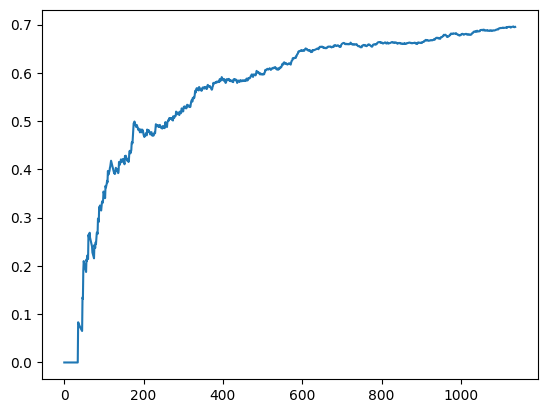

In [7]:
plt.plot(average_clustering_coefficient_list)

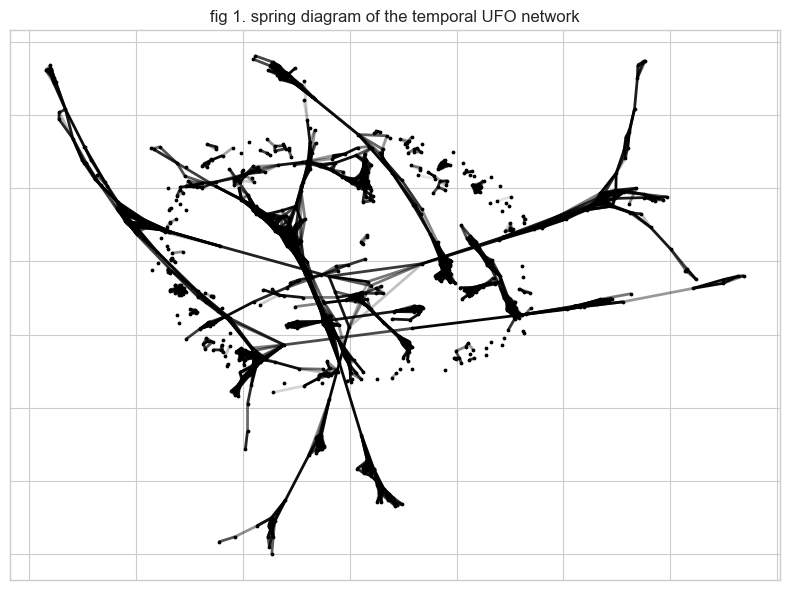

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
plt.style.use('seaborn-v0_8-whitegrid')

edges = ufo_network.edges()
weights = [ufo_network[u][v]['weight'] for u, v in edges]
pos = nx.spring_layout(ufo_network)
nx.draw_networkx_nodes(ufo_network, pos, node_size = 3, node_color='black')
for (i, j), alpha in zip(edges, weights):
    nx.draw_networkx_edges(ufo_network, pos, [(i, j)], alpha=alpha, width=2)
plt.title('fig 1. spring diagram of the temporal UFO network')
plt.tight_layout()
# plt.savefig('spring_diagram.png', dpi = 400)
plt.show()

In [9]:
k_list = [ufo_network.degree(node) for node in ufo_network]
k_min = min(k_list)
k_max = max(k_list)

print(f"Final total size of network: {ufo_network}")
print(f"The average degree of the network is: ", np.mean(k_list))  
print(f"The median degree of the ufo network is: {np.median(k_list)}") 
print(f"The maximum degree of the ufo network is: {max(k_list)}")
print(f"The minimum degree of the ufo network is: {min(k_list)}")

Final total size of network: Graph with 1138 nodes and 7309 edges
The average degree of the network is:  12.845342706502636
The median degree of the ufo network is: 10.0
The maximum degree of the ufo network is: 59
The minimum degree of the ufo network is: 0


In [10]:
C = components(ufo_network)
print("The number of connected components is:", len(C))

C = sorted(C, key=lambda c: len(c), reverse=True)
component_sizes = [len(c) for c in C]

W = nx.adjacency_matrix(ufo_network).toarray()
A = (W != 0).astype(int)

s_array = np.sum(A * W, axis=1)
clustering_coefficient_list = [i for i in nx.clustering(ufo_network).values()]
mean_clustering_coefficient = np.mean(clustering_coefficient_list)
print(f"The node with the highest clustering coefficient is node {clustering_coefficient_list.index(max(clustering_coefficient_list))}, with a clustering coefficient of {max(clustering_coefficient_list)}")
print(f"The average clustering coefficient is: {np.mean(clustering_coefficient_list)}")

The number of connected components is: 93
The node with the highest clustering coefficient is node 6, with a clustering coefficient of 1.0
The average clustering coefficient is: 0.6950346448463334


In [11]:
# weighted clustering coefficient computation
n = len(A)
weighted_clustering_coefficient = np.zeros(n)

for i in range(n):
    if k_list[i] <= 1 or s_array[i] == 0:
        weighted_clustering_coefficient[i] = 0
        continue
    
    # Find neighbors of node i (where a[i,j] = 1)
    neighbors = np.where(A[i] != 0)[0]
    
    # Sum over all pairs of neighbors (j, h)
    total = 0
    for j in neighbors:
        for h in neighbors:
            if j != h:
                total += ((W[i,j] + W[i,h]) / 2) * A[j,h]
    
    weighted_clustering_coefficient[i] = total / (s_array[i] * (k_list[i] - 1))

# print(f"The node with the highest weighted clustering coefficient is node {np.where(clustering_coefficient_list == np.max(clustering_coefficient_list))}, with a clustering coefficient of {max(clustering_coefficient_list)}")
print(f"The average weighted clustering coefficient is: {np.mean(weighted_clustering_coefficient)}")

The average weighted clustering coefficient is: 0.5555772949432066


In [12]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,6))
# # plt.style.use('seaborn-v0_8-whitegrid')

# edges = ufo_network.edges()
# weights = [ufo_network[u][v]['weight'] for u, v in edges]
# pos = nx.spring_layout(ufo_network)
# nx.draw_networkx_nodes(ufo_network, pos, node_size = 2, node_color='black')
# for (u, v), alpha in zip(edges, weights):
#     nx.draw_networkx_edges(ufo_network, pos, [(u, v)], alpha=alpha, width=2)
# plt.title('fig 1. spring diagram of the temporal UFO network')
# plt.tight_layout()
# plt.savefig('spring_diagram.png', dpi = 400)
# plt.show()

In [13]:

fig = plt.figure(figsize=(10,10))
plt.style.use('seaborn-v0_8-whitegrid')
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)
m.fillcontinents(color='limegreen',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

for index in list(ufo_network.nodes()):
    xpt,ypt = m(ufo_network.nodes[index]['lat_long_tuple'][1], ufo_network.nodes[index]['lat_long_tuple'][0])  
    m.plot(xpt,ypt,'ko', markersize = 2)

for init_node, final_node in ufo_network.edges():
    xpt_i, ypt_i = m(ufo_network.nodes[init_node]['lat_long_tuple'][1], 
                    ufo_network.nodes[init_node]['lat_long_tuple'][0])
    xpt_f, ypt_f = m(ufo_network.nodes[final_node]['lat_long_tuple'][1], 
                    ufo_network.nodes[final_node]['lat_long_tuple'][0])
    plt.plot([xpt_i, xpt_f], [ypt_i, ypt_f], 'k-', alpha = ufo_network[init_node][final_node]["weight"])


plt.title("fig 2. geographical map of the temporal UFO network")
plt.ylim(23, 52)
plt.xlim(-127, -67)
plt.xticks(np.arange(-125, -65, 10), labels=[f'{abs(x)}°W' for x in np.arange(-125, -65, 10)])
plt.yticks(np.arange(25, 55, 5), labels=[f'{y}°N' for y in np.arange(25, 55, 5)])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

NameError: name 'Basemap' is not defined

<Figure size 1000x1000 with 0 Axes>

# DEGREE DISTRIBUTION (NOT NEEDED, WEIGHTED DISTRIBUTION IS BETTER)

/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_4080/2102254015.py:11: RuntimeWarning: divide by zero encountered in log10
  log_be = np.log10(bin_edges)


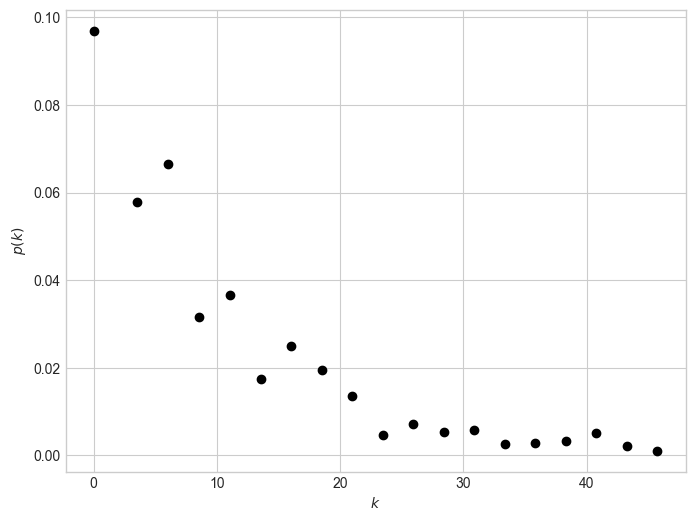

In [ ]:
# Get 20 logarithmically spaced bins between kmin and kmax

bin_edges = np.linspace(k_min, k_max, num=20)

# histogram the data into these bins
density, _ = np.histogram(k_list, bins=bin_edges, density=True)
plt.figure(figsize = (8, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, 'ko')
plt.xlabel(f"$k$")
plt.ylabel(f"$p(k)$")
plt.show()

# WEIGHT DISTRIBUTION

In [16]:
# Get 20 logarithmically spaced bins between kmin and kmax
weight_list = []
for init_node_num in ufo_network:
    for final_node_num in ufo_network:
        if init_node_num != final_node_num and ufo_network.has_edge(init_node_num, final_node_num) == True:
            if ufo_network.edges[init_node_num, final_node_num]['weight'] != np.nan:
            # if ufo_network.has_edge(init_node_num, final_node_num) == True:
                weight_list.append(ufo_network.edges[init_node_num, final_node_num]['weight'])

num_bins = 20
weight_bin_edges = np.linspace(min(weight_list), max(weight_list), num=num_bins)

# histogram the data into these bins
weight_density, _ = np.histogram(weight_list, bins=weight_bin_edges, density=True)
plt.figure(figsize = (8, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(weight_bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, 'ko')
plt.xlabel(f"$w$")
plt.ylabel(f"$p(w)$")
plt.title("fig 3. weight distribution of temporal UFO network")
plt.tight_layout()
plt.show()

/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_3205/4288722908.py:19: RuntimeWarning: divide by zero encountered in log10
  log_be = np.log10(weight_bin_edges)


NameError: name 'density' is not defined

<Figure size 800x600 with 0 Axes>

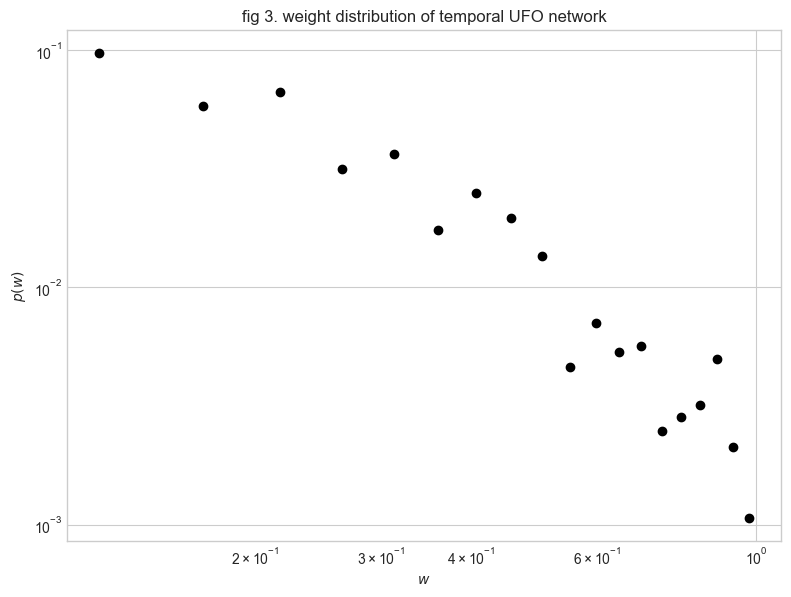

In [124]:
# Get 20 logarithmically spaced bins between kmin and kmax
weight_list = []
for init_node_num in temporal_ufo_network:
    for final_node_num in temporal_ufo_network:
        if init_node_num != final_node_num and temporal_ufo_network.has_edge(init_node_num, final_node_num) == True:
            if temporal_ufo_network.edges[init_node_num, final_node_num]['weight'] != np.nan:
            # if ufo_network.has_edge(init_node_num, final_node_num) == True:
                weight_list.append(temporal_ufo_network.edges[init_node_num, final_node_num]['weight'])

num_bins = 20
weight_bin_edges = np.linspace(min(weight_list), max(weight_list), num=num_bins)

# histogram the data into these bins
weight_density, _ = np.histogram(weight_list, bins=weight_bin_edges, density=True)
plt.figure(figsize = (8, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(weight_bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, 'ko')
plt.xlabel(f"$w$")
plt.ylabel(f"$p(w)$")
plt.title("fig 3. weight distribution of temporal UFO network")
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()